# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [2]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [3]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [4]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] -  asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] -  asl.df['nose-x']
# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [5]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [6]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [7]:
training.get_word_Xlengths('CHOCOLATE')

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [8]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536


In [9]:
# Means for each video
df_vmeans = asl.df.groupby([asl.df.index.get_level_values('video')]).mean()
df_vmeans

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
video,,,,,,,,,,
1,159.877778,149.177778,154.500000,118.822222,162.600000,59.277778,59.544444,-8.100000,89.900000,-2.722222
2,161.160000,150.186667,158.320000,114.426667,163.773333,60.293333,54.133333,-5.453333,89.893333,-2.613333
3,181.112903,188.145161,152.338710,110.629032,172.403226,58.225806,52.403226,-20.064516,129.919355,8.709677
4,144.325581,181.151163,154.313953,119.767442,162.651163,57.267442,62.500000,-8.337209,123.883721,-18.325581
5,170.068493,184.369863,167.219178,116.575342,169.589041,58.369863,58.205479,-2.369863,126.000000,0.479452
6,184.089552,186.820896,162.447761,116.865672,172.253731,52.477612,64.388060,-9.805970,134.343284,11.835821
7,206.223404,223.617021,153.521277,177.978723,172.691489,58.212766,119.765957,-19.170213,165.404255,33.531915
8,206.230769,222.935897,152.987179,177.692308,169.910256,61.730769,115.961538,-16.923077,161.205128,36.320513
9,180.363636,166.402597,157.402597,146.727273,174.000000,59.000000,87.727273,-16.597403,107.402597,6.363636


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [10]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [11]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()
# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938,0.0


In [12]:
df_vstd = asl.df.groupby([asl.df.index.get_level_values('video')]).std()
df_vstd

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean
video,,,,,,,,,,,
1,10.171372,26.000250,12.647556,31.054710,1.541924,2.327306,31.305727,12.677548,27.803100,10.149476,0.0
2,11.247871,25.901943,12.102222,32.718774,2.734036,2.228642,33.492368,12.792833,27.924886,9.646303,0.0
3,1.959465,1.316313,9.909332,40.177571,0.858128,1.497751,40.510456,9.522830,2.058954,2.075518,0.0
4,1.811349,2.161249,14.032116,42.544281,1.272029,0.899992,42.040247,13.774324,2.048923,2.456405,0.0
5,6.519903,3.856837,8.469302,31.288051,3.435257,4.373236,31.667526,7.710935,4.969351,4.868007,0.0
6,5.324988,1.369864,13.404300,29.587003,0.438430,2.630579,31.484462,13.386152,2.465226,5.139264,0.0
7,6.761934,25.913050,11.524382,54.964696,2.782536,4.678646,53.782202,12.864587,27.108432,7.375784,0.0
8,10.402201,26.495449,11.577512,49.836696,1.186350,1.325799,49.370700,11.969408,26.633813,10.969253,0.0
9,22.234935,18.437133,21.364173,27.165011,0.000000,0.000000,27.165011,21.364173,18.437133,22.234935,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [13]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd
asl.df['ry-mean'] = asl.df['speaker'].map(df_means['right-y'])
asl.df['rx-mean'] = asl.df['speaker'].map(df_means['right-x'])
asl.df['ly-mean'] = asl.df['speaker'].map(df_means['left-y'])
asl.df['lx-mean'] = asl.df['speaker'].map(df_means['left-x'])

asl.df['ry-std'] = asl.df['speaker'].map(df_std['right-y'])
asl.df['rx-std'] = asl.df['speaker'].map(df_std['right-x'])
asl.df['ly-std'] = asl.df['speaker'].map(df_std['left-y'])
asl.df['lx-std'] = asl.df['speaker'].map(df_std['left-x'])

asl.df['norm-rx'] = (asl.df['right-x'] - asl.df['rx-mean']) / asl.df['rx-std']
asl.df['norm-ry'] = (asl.df['right-y'] - asl.df['ry-mean']) / asl.df['ry-std']
asl.df['norm-lx'] = (asl.df['left-x'] - asl.df['lx-mean']) / asl.df['lx-std']
asl.df['norm-ly'] = (asl.df['left-y'] - asl.df['ly-mean']) / asl.df['ly-std']

# 'grnd' normalized values
asl.df['grnd-ry-mean'] = asl.df['speaker'].map(df_means['grnd-ry'])
asl.df['grnd-rx-mean'] = asl.df['speaker'].map(df_means['grnd-rx'])
asl.df['grnd-ly-mean'] = asl.df['speaker'].map(df_means['grnd-ly'])
asl.df['grnd-lx-mean'] = asl.df['speaker'].map(df_means['grnd-lx'])

asl.df['grnd-ry-std'] = asl.df['speaker'].map(df_std['grnd-ry'])
asl.df['grnd-rx-std'] = asl.df['speaker'].map(df_std['grnd-rx'])
asl.df['grnd-ly-std'] = asl.df['speaker'].map(df_std['grnd-ly'])
asl.df['grnd-lx-std'] = asl.df['speaker'].map(df_std['grnd-lx'])

asl.df['grnd-norm-rx'] = (asl.df['grnd-rx'] - asl.df['grnd-rx-mean']) / asl.df['grnd-rx-std']
asl.df['grnd-norm-ry'] = (asl.df['grnd-ry'] - asl.df['grnd-ry-mean']) / asl.df['grnd-ry-std']
asl.df['grnd-norm-lx'] = (asl.df['grnd-lx'] - asl.df['grnd-lx-mean']) / asl.df['grnd-lx-std']
asl.df['grnd-norm-ly'] = (asl.df['grnd-ly'] - asl.df['grnd-ly-mean']) / asl.df['grnd-ly-std']

# NORMALIZED FEATURE SET
features_norm = ['norm-rx', 'norm-ry', 'norm-lx', 'norm-ly']
features_grnd_norm = ['grnd-norm-rx', 'grnd-norm-ry', 'grnd-norm-lx', 'grnd-norm-ly'] 
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly      ...       grnd-ly-mean  \
video frame                                 ...                      
98    0          113        9      119      ...         104.026144   
      1          113        9      119      ...         104.026144   
      2          113        9      119      ...         104.026144   
      3          113        9      119      ...         104.026144   
      4          113        9      119      ...         104.026144   

             grnd-lx-mean  grnd-ry-std  grnd-rx-std  grnd-ly-std  grnd-lx-std  \
video frame                                                                     
98    0          2.006318     33.97266    16.764706    27.117393    17.328941   
      1          2.006318     33.97266    16.764706    27.117393    17.328941   
      2          2.006318     33.97266    16.764706    27.117393    17.328941   
      3          2.006318     33.97266    16.764706    27.117393    17.328941   
      4          2.006318     33.97266    16.764706    27.117393    17.328941   

             grnd-norm-rx  grnd-norm-ry  grnd-norm-lx  grnd-norm-ly  
video frame                                                          
98    0          1.230994      1.557506     -0.808262      0.552186  
      1          1.230994      1.557506     -0.808262      0.552186  
      2          1.230994      1.557506     -0.808262      0.552186  
      3          1.230994      1.557506     -0.808262      0.552186  
      4          1.230994      1.557506     -0.808262      0.552186  

[5 rows x 36 columns]

In [14]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle
asl.df['polar-rr'] = (asl.df['grnd-rx'].pow(2) + asl.df['grnd-ry'].pow(2)).pow(1/2)
asl.df['polar-lr'] = (asl.df['grnd-lx'].pow(2) + asl.df['grnd-ly'].pow(2)).pow(1/2)

asl.df['polar-rtheta'] = np.arctan2(asl.df['grnd-rx'], asl.df['grnd-ry'])
asl.df['polar-ltheta'] = np.arctan2(asl.df['grnd-lx'], asl.df['grnd-ly'])

# POLAR FEATURE SET
features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly      ...       grnd-ly-std  \
video frame                                 ...                     
98    0          113        9      119      ...         27.117393   
      1          113        9      119      ...         27.117393   
      2          113        9      119      ...         27.117393   
      3          113        9      119      ...         27.117393   
      4          113        9      119      ...         27.117393   

             grnd-lx-std  grnd-norm-rx  grnd-norm-ry  grnd-norm-lx  \
video frame                                                          
98    0        17.328941      1.230994      1.557506     -0.808262   
      1        17.328941      1.230994      1.557506     -0.808262   
      2        17.328941      1.230994      1.557506     -0.808262   
      3        17.328941      1.230994      1.557506     -0.808262   
      4        17.328941      1.230994      1.557506     -0.808262   

             grnd-norm-ly   polar-rr    polar-lr  polar-rtheta  polar-ltheta  
video frame                                                                   
98    0          0.552186  113.35784  119.603512      0.079478     -0.100501  
      1          0.552186  113.35784  119.603512      0.079478     -0.100501  
      2          0.552186  113.35784  119.603512      0.079478     -0.100501  
      3          0.552186  113.35784  119.603512      0.079478     -0.100501  
      4          0.552186  113.35784  119.603512      0.079478     -0.100501  

[5 rows x 40 columns]

In [15]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

asl.df['delta-rx'] = asl.df['right-x'].diff().fillna(0.0)
asl.df.loc[(asl.df.index.get_level_values('frame') == 0), 'delta-rx'] = 0
asl.df['delta-ry'] = asl.df['right-y'].diff().fillna(0.0)
asl.df.loc[(asl.df.index.get_level_values('frame') == 0), 'delta-ry'] = 0
asl.df['delta-lx'] = asl.df['left-x'].diff().fillna(0.0)
asl.df.loc[(asl.df.index.get_level_values('frame') == 0), 'delta-lx'] = 0
asl.df['delta-ly'] = asl.df['left-y'].diff().fillna(0.0)
asl.df.loc[(asl.df.index.get_level_values('frame') == 0), 'delta-ly'] = 0

# DELTA FEATURE SET
features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

asl.df['grnd-delta-rx'] = asl.df['grnd-norm-rx'].diff().fillna(0.0)
asl.df.loc[(asl.df.index.get_level_values('frame') == 0), 'grnd-delta-rx'] = 0
asl.df['grnd-delta-ry'] = asl.df['grnd-norm-ry'].diff().fillna(0.0)
asl.df.loc[(asl.df.index.get_level_values('frame') == 0), 'grnd-delta-ry'] = 0
asl.df['grnd-delta-lx'] = asl.df['grnd-norm-lx'].diff().fillna(0.0)
asl.df.loc[(asl.df.index.get_level_values('frame') == 0), 'grnd-delta-lx'] = 0
asl.df['grnd-delta-ly'] = asl.df['grnd-norm-ly'].diff().fillna(0.0)
asl.df.loc[(asl.df.index.get_level_values('frame') == 0), 'grnd-delta-ly'] = 0

features_grnd_delta = ['grnd-delta-rx', 'grnd-delta-ry', 'grnd-delta-lx', 'grnd-delta-ly']

asl.df[0:1000]

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   
      5         149     181      170      175     161      62  woman-1   
      6         149     181      170      175     161      62  woman-1   
      7         149     181      170      175     161      62  woman-1   
      8         149     181      170      175     161      62  woman-1   
      9         149     181      170      175     161      62  woman-1   
      10        149     181      170      175     161      62  woman-1   
      11        149     181      169      173     161      62  woman-1   
      12        149     181      167      165     161      62  woman-1   
      13        149     181      166      160     161      62  woman-1   
      14        149     181      164      149     161      62  woman-1   
      15        149     181      158      133     161      62  woman-1   
      16        149     181      153      119     161      62  woman-1   
      17        149     181      140      109     161      62  woman-1   
      18        149     181      126      100     163      58  woman-1   
      19        149     181      114       94     163      58  woman-1   
      20        149     181      110       89     163      58  woman-1   
      21        149     181      110       89     162      56  woman-1   
      22        149     181      115       86     162      56  woman-1   
      23        149     181      124       83     162      56  woman-1   
      24        149     181      127       84     162      56  woman-1   
      25        149     181      132       83     162      54  woman-1   
      26        149     181      135       82     162      54  woman-1   
      27        149     181      138       79     162      54  woman-1   
      28        149     181      141       75     162      54  woman-1   
      29        149     181      141       75     162      54  woman-1   
...             ...     ...      ...      ...     ...     ...      ...   
95    63        201     160      165      160     182      62    man-1   
      64        206     162      165      160     182      62    man-1   
      65        203     167      165      165     182      62    man-1   
      66        202     174      164      173     182      62    man-1   
      67        202     182      167      182     182      62    man-1   
      68        199     194      165      193     182      62    man-1   
      69        199     213      163      209     179      64    man-1   
      70        198     220      164      222     179      64    man-1   
      71        196     236      162      236     179      64    man-1   
      72        197     239      162      238     179      64    man-1   
      73        197     239      162      238     179      64    man-1   
      74        197     239      162      238     179      64    man-1   
      75        197     239      162      238     178      68    man-1   
      76        197     239      162      238     178      68    man-1   
      77        197     239      162      238     178      68    man-1   
      78        197     239      162      238     178      68    man-1   
      79        197     239      162      238     178      74    man-1   
      80        197     239      162      238     178      74    man-1   
      81        197     239      162      238     178      74    man-1   
      82        197     239      162      238     178      74    man-1   
      83        197     239      162      238     178      74    man-1   
96    0         2

In [16]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like
asl.df['polar-ltheta-custom'] = np.arctan2(asl.df['grnd-norm-lx'], asl.df['grnd-norm-ly']) / np.pi
asl.df['polar-rtheta-custom'] = np.arctan2(asl.df['grnd-norm-rx'], asl.df['grnd-norm-ry']) / np.pi

'''
# Tie a corrdinate system to the video
idx = asl.df.index.get_level_values('video')

asl.df['ry-vmean'] = asl.df[idx].map(df_vmeans['right-y'])
asl.df['rx-vmean'] = asl.df[idx].map(df_vmeans['right-x'])
asl.df['ly-vmean'] = asl.df[idx].map(df_vmeans['left-y'])
asl.df['lx-vmean'] = asl.df[idx].map(df_vmeans['left-x'])

asl.df['ry-vstd'] = asl.df[idx].map(df_vstd['right-y'])
asl.df['rx-vstd'] = asl.df[idx].map(df_vstd['right-x'])
asl.df['ly-vstd'] = asl.df[idx].map(df_vstd['left-y'])
asl.df['lx-vstd'] = asl.df[idx].map(df_vstd['left-x'])

x_mean = (asl.df['rx-vmean'] + asl.df['lx-vmean']) / 2
y_mean = (asl.df['ry-vmean'] + asl.df['ly-vmean']) / 2

asl.df['vnorm-rx'] = (asl.df['right-x'] - x_mean) / asl.df['rx-vstd']
asl.df['vnorm-ry'] = (asl.df['right-y'] - y_mean) / asl.df['ry-vstd']
asl.df['vnorm-lx'] = (asl.df['left-x'] - x_mean) / asl.df['lx-vstd']
asl.df['vnorm-ly'] = (asl.df['left-x'] - y_mean) / asl.df['ly-vstd']
'''

# Triangle
left_nose = (asl.df['grnd-norm-lx'].pow(2) + asl.df['grnd-norm-ly'].pow(2)).pow(1/2) # a
right_nose = (asl.df['grnd-norm-rx'].pow(2) + asl.df['grnd-norm-ry'].pow(2)).pow(1/2) # b
left_right = (
    (asl.df['grnd-norm-rx'] - asl.df['grnd-norm-lx']).pow(2) + 
    (asl.df['grnd-norm-ry'] - asl.df['grnd-norm-ly']).pow(2)).pow(1/2) # c

cos_a1 = (right_nose.pow(2)  + left_right.pow(2) - left_nose.pow(2)) / (2 * right_nose * left_right)
cos_a2 = (left_right.pow(2)  + left_nose.pow(2) - right_nose.pow(2)) / (2 * left_right * left_nose)
cos_a3 = (left_nose.pow(2)  + right_nose.pow(2) - left_right.pow(2)) / (2 * left_nose * right_nose)

s = (left_nose + right_nose + left_right) / 2

asl.df['angle-1'] = np.arccos(cos_a1)
asl.df['angle-2'] = np.arccos(cos_a2)
asl.df['angle-3'] = np.arccos(cos_a3)
asl.df['tri-area'] = (s*(s - left_nose)*(s - right_nose)*(s - left_right)) #.pow(1/2)
asl.df['left-right'] = left_right
#asl.df['right-nose'] = right_nose
#asl.df['left-nose'] = left_nose
x = asl.df['grnd-norm-rx'] - asl.df['grnd-norm-lx']
y = asl.df['grnd-norm-ry'] - asl.df['grnd-norm-ly']
asl.df['theta-lr'] = np.arctan2(y, x) / np.pi
x_mid = (asl.df['grnd-norm-rx'] + asl.df['grnd-norm-lx']) / 2
y_mid = (asl.df['grnd-norm-ry'] + asl.df['grnd-norm-ly']) / 2
asl.df['nose-lr'] = (x_mid.pow(2) + y_mid.pow(2)).pow(1/2)
asl.df['theta-nose-lr'] = (np.arctan2(x_mid, y_mid) / np.pi).pow(2)

asl.df['lr-delta'] = asl.df['left-right'].diff().fillna(0.0)
asl.df.loc[(asl.df.index.get_level_values('frame') == 0), 'lr-delta'] = 0
asl.df['nose-delta-lr'] = asl.df['nose-lr'].diff().fillna(0.0)
asl.df.loc[(asl.df.index.get_level_values('frame') == 0), 'nose-delta-lr'] = 0
asl.df['theta-delta-lr'] = asl.df['theta-lr'].diff().fillna(0.0)
asl.df.loc[(asl.df.index.get_level_values('frame') == 0), 'theta-delta-lr'] = 0
asl.df['theta-nose-delta-lr'] = asl.df['theta-nose-lr'].diff().fillna(0.0)
asl.df.loc[(asl.df.index.get_level_values('frame') == 0), 'theta-nose-delta-lr'] = 0
asl.df['tri-area-delta'] = asl.df['tri-area'].diff().fillna(0.0)
asl.df.loc[(asl.df.index.get_level_values('frame') == 0), 'tri-area-delta'] = 0

# TODO define a list named 'features_custom' for building the training set

# CUSTOM FEATURE SET
features_custom = ['left-right', 'nose-lr', 'tri-area', 'theta-nose-lr',
                   'polar-ltheta-custom', 'polar-rtheta-custom', 'tri-area']
asl.df[0:1000]

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   
      5         149     181      170      175     161      62  woman-1   
      6         149     181      170      175     161      62  woman-1   
      7         149     181      170      175     161      62  woman-1   
      8         149     181      170      175     161      62  woman-1   
      9         149     181      170      175     161      62  woman-1   
      10        149     181      170      175     161      62  woman-1   
      11        149     181      169      173     161      62  woman-1   
      12        149     181      167      165     161      62  woman-1   
      13        149     181      166      160     161      62  woman-1   
      14        149     181      164      149     161      62  woman-1   
      15        149     181      158      133     161      62  woman-1   
      16        149     181      153      119     161      62  woman-1   
      17        149     181      140      109     161      62  woman-1   
      18        149     181      126      100     163      58  woman-1   
      19        149     181      114       94     163      58  woman-1   
      20        149     181      110       89     163      58  woman-1   
      21        149     181      110       89     162      56  woman-1   
      22        149     181      115       86     162      56  woman-1   
      23        149     181      124       83     162      56  woman-1   
      24        149     181      127       84     162      56  woman-1   
      25        149     181      132       83     162      54  woman-1   
      26        149     181      135       82     162      54  woman-1   
      27        149     181      138       79     162      54  woman-1   
      28        149     181      141       75     162      54  woman-1   
      29        149     181      141       75     162      54  woman-1   
...             ...     ...      ...      ...     ...     ...      ...   
95    63        201     160      165      160     182      62    man-1   
      64        206     162      165      160     182      62    man-1   
      65        203     167      165      165     182      62    man-1   
      66        202     174      164      173     182      62    man-1   
      67        202     182      167      182     182      62    man-1   
      68        199     194      165      193     182      62    man-1   
      69        199     213      163      209     179      64    man-1   
      70        198     220      164      222     179      64    man-1   
      71        196     236      162      236     179      64    man-1   
      72        197     239      162      238     179      64    man-1   
      73        197     239      162      238     179      64    man-1   
      74        197     239      162      238     179      64    man-1   
      75        197     239      162      238     178      68    man-1   
      76        197     239      162      238     178      68    man-1   
      77        197     239      162      238     178      68    man-1   
      78        197     239      162      238     178      68    man-1   
      79        197     239      162      238     178      74    man-1   
      80        197     239      162      238     178      74    man-1   
      81        197     239      162      238     178      74    man-1   
      82        197     239      162      238     178      74    man-1   
      83        197     239      162      238     178      74    man-1   
96    0         2

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:**

I wanted to select features that I felt best represented visual cues like the relative orientation and distance between the hands and relative proximity of this motion to the nose. I like the translational invariance of the ground features however the coupling of the hands to the motion of the nose and vice versa meant features like position and distance would carry mixed information about the motion of the hands and nose that could not be decoupled. The distance between the hands and the angle of the line connecting the hands relative to the video frame are invariant of the motion of the nose. Information about the position of the nose relative to the hands could be reintroduced without affecting the features for the hands by specifying the distance between the nose and the midpoint of the line connecting the hands along with the relative angle of the two lines. 

The rest was trial and error looking for features that produced distinct states with O(1) variance. 

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [17]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.009s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [18]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
# model, logL = train_a_word(demoword, 3, features_custom)
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.113812743317


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [19]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
variance =  [  77.403668    203.35441965   26.68898447  156.12444034]

hidden state #1
mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
variance =  [ 19.70434594  16.83041492  30.51552305  11.03678246]

hidden state #2
mean =  [ -3.46504869  50.66686933  14.02391587  52.04731066]
variance =  [ 49.12346305  43.04799144  39.35109609  47.24195772]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [20]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_custom) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [ 2.77698236  0.78868135  0.75744042  0.88343191 -0.78244562  0.51635406
  0.75744042]
variance =  [ 0.05016075  0.00737745  0.02180208  0.00341217  0.00233362  0.00147006
  0.02180208]

hidden state #1
mean =  [ 1.63252321  0.88599006  0.12348694  0.9285992  -0.90356087  0.62976552
  0.12348694]
variance =  [ 0.05914946  0.02011079  0.0093778   0.00311736  0.0028987   0.08725994
  0.0093778 ]

hidden state #2
mean =  [ 0.99045194  0.35440595  0.01742222  0.61238994 -0.02842755  0.45758604
  0.01742222]
variance =  [  1.31175600e-01   1.34430249e-02   6.51546184e-04   5.08989226e-02
   7.69327607e-01   4.36069773e-02   6.51546184e-04]

logL = 247.3870011552577


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [21]:
%matplotlib inline

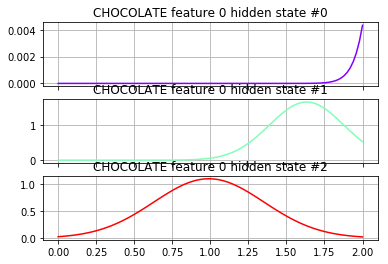

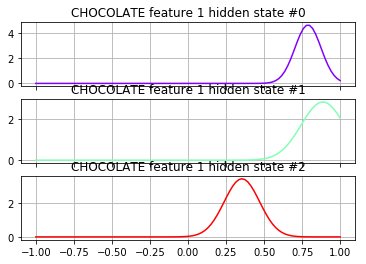

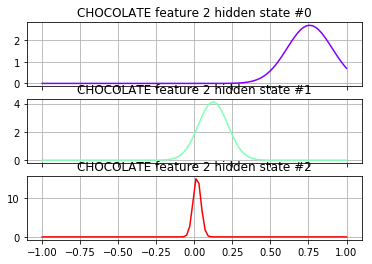

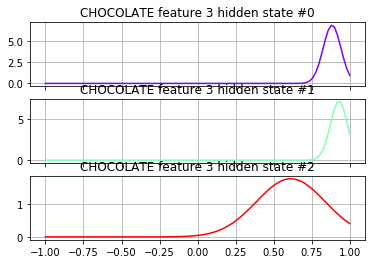

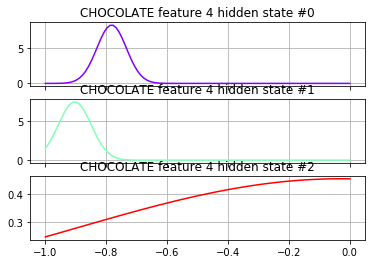

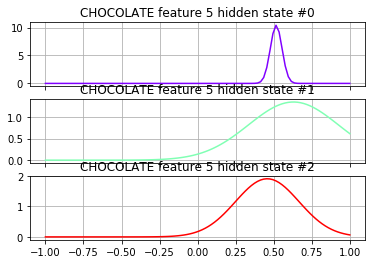

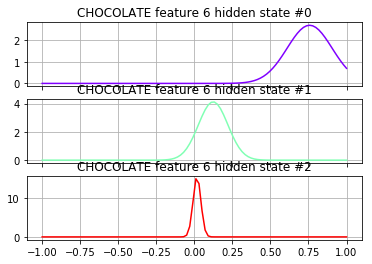

In [23]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        if xmax == xmin:
            xmax += 1
            xmin -= 1
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [24]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [25]:
from sklearn.model_selection import KFold

#training = asl.build_training(features_ground) # Experiment here with different feature sets
training = asl.build_training(features_custom) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [26]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [33]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
# TODO: Implement SelectorCV in my_model_selectors.py
from my_model_selectors import SelectorCV

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))


Training complete for FISH with 11 states with time 0.3500802490161732 seconds
Training complete for BOOK with 6 states with time 3.81353125104215 seconds
Training complete for VEGETABLE with 2 states with time 1.469059017021209 seconds
Training complete for FUTURE with 2 states with time 3.449692134046927 seconds
Training complete for JOHN with 12 states with time 38.14533113699872 seconds


In [29]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 5 states with time 0.2807241069385782 seconds
Training complete for BOOK with 8 states with time 1.910018148017116 seconds
Training complete for VEGETABLE with 9 states with time 0.6264617299893871 seconds
Training complete for FUTURE with 9 states with time 2.2059778230031952 seconds
Training complete for JOHN with 13 states with time 20.155005863984115 seconds


In [30]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.692243630066514 seconds
Training complete for BOOK with 15 states with time 3.7366903621004894 seconds
Training complete for VEGETABLE with 15 states with time 2.5613822899758816 seconds
Training complete for FUTURE with 15 states with time 3.98880186106544 seconds
Training complete for JOHN with 15 states with time 21.260681865969673 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**

**CV** has the advantage of testing models on unseen data which is robust against over fitting however it must rerun model training for each kflold give it a larger computational overhead than other selectors. **BIC** attempts to balance complexity and performance with a modified logL score that is penalized for complexity meaning a larger parameter space demands and increasingly large logL score to verify that the model is still likely to require the higher dimensional feature space to maximize it predictive utility. **DIC** unlike **BIC** doesn't rely on assumptions about the structure of information in the models rather it scores the model based on how well scores itself. **DIC** assumes  the distribution of all models produced by the data lies on top of the best model and the model that is closest to the true model will have the highest average score among all other samples. However the assumption in **DIC**  about the distribution of models will tend to over fit on small training sets. 

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [32]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 46.849s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [35]:
from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [36]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [37]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

In [50]:
# TODO Choose a feature set and model selector
features = features_ground # change as needed
model_selector = SelectorCV # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5224719101123596
Total correct: 85 out of 178
Video  Recognized                                                    Correct
    2: JOHN *COAT *ARRIVE                                            JOHN WRITE HOMEWORK
    7: JOHN *GO1 *HAVE *WHAT                                         JOHN CAN GO CAN
   12: *IX CAN *CAN CAN                                              JOHN CAN GO CAN
   21: JOHN *HOMEWORK *JOHN *TELL *CAR *CAR EAT *BROTHER             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *TELL IX *TELL IX                                        JOHN LIKE IX IX IX
   28: JOHN *TELL IX IX IX                                           JOHN LIKE IX IX IX
   30: JOHN LIKE IX *MARY IX                                         JOHN LIKE IX IX IX
   36: *WHO VEGETABLE *IX *GIVE *BILL *MARY                          MARY VEGETABLE KNOW IX LIKE CORN1
   40: *JANA *BILL *FUTURE1 *JANA *IX                                JOHN IX THINK MARY LOVE
   43: JOHN *SHOULD BUY HOUSE        

In [49]:
# TODO Choose a feature set and model selector
features = features_grnd_delta # change as needed
model_selector = SelectorDIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5842696629213483
Total correct: 74 out of 178
Video  Recognized                                                    Correct
    2: JOHN *IX HOMEWORK                                             JOHN WRITE HOMEWORK
    7: JOHN *VISIT *IX *VISIT                                        JOHN CAN GO CAN
   12: JOHN *BOX *GO1 CAN                                            JOHN CAN GO CAN
   21: JOHN *MARY *JOHN *MARY *IX *FUTURE *MARY *MARY                JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX IX *JOHN IX                                          JOHN LIKE IX IX IX
   28: JOHN *MARY IX IX IX                                           JOHN LIKE IX IX IX
   30: JOHN *CORN *SOMETHING-ONE IX IX                               JOHN LIKE IX IX IX
   36: MARY *JOHN *SHOULD *LOVE *WOMAN *MARY                         MARY VEGETABLE KNOW IX LIKE CORN1
   40: *CHINA IX *MARY *GIVE1 *SOMETHING-ONE                         JOHN IX THINK MARY LOVE
   43: JOHN *NOT BUY HOUSE           

In [48]:
# TODO Choose a feature set and model selector
features = features_ground + features_grnd_delta # change as needed
model_selector = SelectorBIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.43820224719101125
Total correct: 100 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE *ARRIVE                                            JOHN WRITE HOMEWORK
    7: JOHN *CAR GO *CAR                                             JOHN CAN GO CAN
   12: JOHN CAN *WHAT CAN                                            JOHN CAN GO CAN
   21: JOHN *ARRIVE WONT *WHO *CAR *CAR *FUTURE *MARY                JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE IX IX IX                                            JOHN LIKE IX IX IX
   28: JOHN *WHO IX IX IX                                            JOHN LIKE IX IX IX
   30: JOHN LIKE *LOVE IX IX                                         JOHN LIKE IX IX IX
   36: MARY *VISIT *IX *GIVE *MARY *MARY                             MARY VEGETABLE KNOW IX LIKE CORN1
   40: *SOMETHING-ONE *GO *JOHN MARY LOVE                            JOHN IX THINK MARY LOVE
   43: JOHN *JOHN BUY HOUSE        

In [47]:
# TODO Choose a feature set and model selector
features_set = [features_custom,
                features_ground, features_grnd_delta,
                features_ground + features_grnd_delta] # change as needed
model_selector_set = [SelectorCV, SelectorBIC, SelectorDIC] # change as needed

# TODO Recognize the test set and display the result with the show_errors method
for features in features_set:
    for model_selector in model_selector_set:
        models = train_all_words(features, model_selector)
        test_set = asl.build_test(features)
        probabilities, guesses = recognize(models, test_set)
        print('features: {}    model_selector: {}'.format(features, model_selector.__name__))
        show_errors(guesses, test_set)

features: ['left-right', 'nose-lr', 'tri-area', 'theta-nose-lr', 'polar-ltheta-custom', 'polar-rtheta-custom', 'tri-area']    model_selector: SelectorCV
**** WER = 0.6067415730337079
Total correct: 70 out of 178
features: ['left-right', 'nose-lr', 'tri-area', 'theta-nose-lr', 'polar-ltheta-custom', 'polar-rtheta-custom', 'tri-area']    model_selector: SelectorBIC
**** WER = 0.5842696629213483
Total correct: 74 out of 178
features: ['left-right', 'nose-lr', 'tri-area', 'theta-nose-lr', 'polar-ltheta-custom', 'polar-rtheta-custom', 'tri-area']    model_selector: SelectorDIC
**** WER = 0.550561797752809
Total correct: 80 out of 178
features: ['grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly']    model_selector: SelectorCV
**** WER = 0.5224719101123596
Total correct: 85 out of 178
features: ['grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly']    model_selector: SelectorBIC
**** WER = 0.550561797752809
Total correct: 80 out of 178
features: ['grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly']    model_selector: S

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**

On average ‘SelectorCV’ did the best though not by a large margin and in particular performed better than other selectors when faced with a smaller feature space.  I was surprised that the ground positional values performed better than the ground-normalized delta values which can only suggest that the path one traverses while signing contains more information then the rate at which one traces that path. While the model does its best with the combination of positional and rate information much like adding the first derivative to improve a function approximation. By increasing the depth of the feature space with nontrivial information we can see that, regardless of model selection the combined feature space does better overall. 

To improve WER several things come to mind from the lectures. First, obviously is more training data. Second would be to train on phrases to capture the transitional features that change the beginning and end stats of word features. Third, the robust application of statistics surround language that can further constrain our models. 

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [51]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 25.960s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [ ]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()